In [1]:
! pip install openpyxl torch numpy pandas seaborn scikit-learn scipy matplotlib transformers gensim

In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging

import warnings
warnings.filterwarnings("ignore")

logging.set_verbosity_error()

/home/anhcd/miniconda3/envs/bert/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    
    if torch.cuda.is_available(): 
        print("Torch available")
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed_everything(86)

Torch available


In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
EPOCHS = 6
N_SPLITS = 5

# Load Data

In [15]:
def get_data(path):
    if path.lower().endswith(".csv"):
        df = pd.read_csv(path)
    elif path.lower().endswith(".xlsx"):
        df = pd.read_excel(path, sheet_name=None)['Sheet1']
    df.columns = ['id', 'text', 'label']
    # unused column
    df.drop(columns=['id'], inplace=True)
    return df

train_df = get_data('/home/anhcd/Projects/bert-text-classification/train.csv')
test_df = get_data('/home/anhcd/Projects/bert-text-classification/test.csv')
# test_df = get_data('../input/UIT-VSMEC/test_nor_811.xlsx')

# We will use Kfold later
# train_df = pd.concat([train_df, valid_df], ignore_index=True)
skf = StratifiedKFold(n_splits=N_SPLITS)
for fold, (_, val_) in enumerate(skf.split(X=train_df, y=train_df.label)):
    train_df.loc[val_, "kfold"] = fold

In [16]:
train_df.sample(10)

text               label  \
12573  htc one mini sẽ có giá không rẻ tại việt_nam đ...  __label__công_nghệ   
28051  hàng trăm két bia đè 2 người đi xe_máy thời_sự...    __label__thời_sự   
19008  những thủ_thuật ít người biết trên nova 3e côn...  __label__công_nghệ   
30008  hamburg tậu tân_binh đầu_tiên từ chelsea cup c...   __label__thể_thao   
33034  bentley ra_mắt continental bản đặc_biệt siêu x...     __label__xe_360   
33337  đoán tính_cách bạn qua màu mắt yêu_thích trắc_...  __label__nhịp_sống   
16841  cách sử_dụng áo_mưa dành cho phái_đẹp sức_khỏe...   __label__sức_khỏe   
13448  máy_ảnh canon chính hãng tuyên_chiến với hàng_...  __label__công_nghệ   
14075  thanh_niên 9x tử_vong vì trượt chân rơi xuống ...    __label__thời_sự   
28368  khai_trương pico 148 giảng_võ khuyến_mại sốc t...  __label__nhịp_sống   

       kfold  
12573    1.0  
28051    3.0  
19008    2.0  
30008    4.0  
33034    4.0  
33337    4.0  
16841    2.0  
13448    1.0  
14075    1.0  
28368    3.0

In [6]:
train_df.info(), test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37342 entries, 0 to 37341
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   text    37342 non-null  object 
 1   label   37342 non-null  object 
 2   kfold   37342 non-null  float64
dtypes: float64(1), object(2)
memory usage: 875.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9336 entries, 0 to 9335
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    9336 non-null   object
 1   label   9336 non-null   object
dtypes: object(2)
memory usage: 146.0+ KB


(None, None)

<Axes: xlabel='label', ylabel='count'>

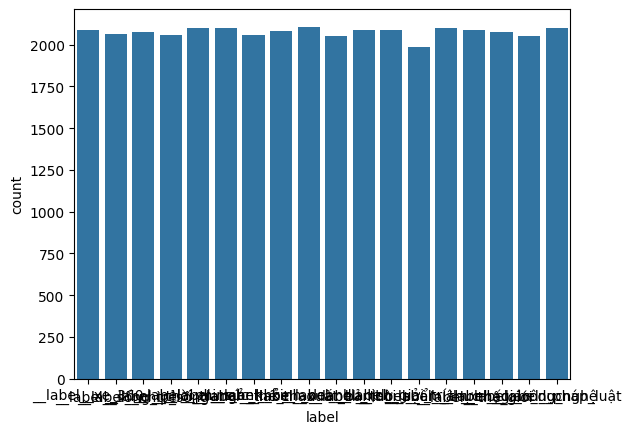

In [7]:
sns.countplot(x='label', data=train_df)

# DataLoader

In [12]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

In [15]:
class ClassifyDataset(Dataset):
    def __init__(self, df, tokenizer, classes, max_len=258):
        self.df = df
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.classes = classes
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        """
        To customize dataset, inherit from Dataset class and implement
        __len__ & __getitem__
        __getitem__ should return 
            data:
                input_ids
                attention_masks
                text
                targets
        """
        row = self.df.iloc[index]
        text, label = self.get_input_data(row)

        # Encode_plus will:
        # (1) split text into token
        # (2) Add the '[CLS]' and '[SEP]' token to the start and end
        # (3) Truncate/Pad sentence to max length
        # (4) Map token to their IDS
        # (5) Create attention mask
        # (6) Return a dictionary of outputs
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )
        
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_masks': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long),
        }


    def labelencoder(self,text):
        for i in range(len(self.classes)):
            if text == self.classes[i]:
                return i

    def get_input_data(self, row):
        # Preprocessing: {remove icon, special character, lower}
        text = row['text']
        text = ' '.join(simple_preprocess(text))
        label = self.labelencoder(row['label'])

        return text, label

In [17]:
classes = train_df["label"].unique()
print(len(classes))
print(classes)

18
['__label__xe_360' '__label__sống_trẻ' '__label__nhịp_sống'
 '__label__thời_trang' '__label__phim_ảnh' '__label__sức_khỏe'
 '__label__thể_thao' '__label__kinh_doanh' '__label__xuất_bản'
 '__label__du_lịch' '__label__thời_sự' '__label__giải_trí'
 '__label__ẩm_thực' '__label__âm_nhạc' '__label__thế_giới'
 '__label__giáo_dục' '__label__công_nghệ' '__label__pháp_luật']


In [28]:
for text in train_df["text"]:
    if "@" in text:
        print("detected")

BERT works with fixed-length sequences. We’ll use a simple strategy to choose the max length.

Text(0.5, 9.444444444444438, 'Token Count')

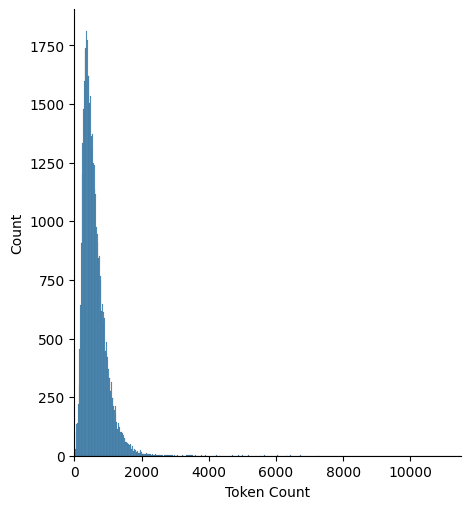

In [14]:
# Distribution of length of Sentence
all_data = train_df.text.tolist() + test_df.text.tolist()
all_data = [' '.join(simple_preprocess(text)) for text in all_data]
encoded_text = [tokenizer.encode(text, add_special_tokens=True) for text in all_data]
token_lens = [len(text) for text in encoded_text]
sns.displot(token_lens)
plt.xlim([0,max(token_lens)])
plt.xlabel('Token Count')

# Model

In [4]:
class BERTClassifier(nn.Module):
    def __init__(self, n_classes):
        super(BERTClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("vinai/phobert-base")
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False # Dropout will errors if without this
        )

        x = self.drop(output)
        x = self.fc(x)
        return x

# Train & Eval Function

In [12]:
def train(model, criterion, optimizer, train_loader, lr_scheduler):
    model.train()
    losses = []
    correct = 0

    for data in train_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = criterion(outputs, targets)
        _, pred = torch.max(outputs, dim=1)

        correct += torch.sum(pred == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()

    print(f'Train Accuracy: {correct.double()/len(train_loader.dataset)} Loss: {np.mean(losses)}')

def eval(model, valid_loader, criterion):
    model.eval()
    losses = []
    correct = 0

    with torch.no_grad():
        for data in valid_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_masks'].to(device)
            targets = data['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, pred = torch.max(outputs, dim=1)

            loss = criterion(outputs, targets)
            correct += torch.sum(pred == targets)
            losses.append(loss.item())
    
    print(f'Valid Accuracy: {correct.double()/len(valid_loader.dataset)} Loss: {np.mean(losses)}')
    return correct.double()/len(valid_loader.dataset)

# Training with K-Fold

In [13]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = ClassifyDataset(df_train, tokenizer, classes, max_len=256)
    valid_dataset = ClassifyDataset(df_valid, tokenizer, classes, max_len=256)
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
    valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True, num_workers=2)
    
    return train_loader, valid_loader

In [15]:
def test(data_loader):
    models = []
    for fold in range(skf.n_splits):
        model = BERTClassifier(n_classes=18)
        model.to(device)
        model.load_state_dict(torch.load(f'phobert_fold{fold+1}.pth'))
        model.eval()
        models.append(model)

    texts = []
    predicts = []
    predict_probs = []
    real_values = []

    for data in data_loader:
        text = data['text']
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        total_outs = []
        for model in models:
            with torch.no_grad():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                total_outs.append(outputs)
        
        total_outs = torch.stack(total_outs)
        _, pred = torch.max(total_outs.mean(0), dim=1)
        texts.extend(text)
        predicts.extend(pred)
        predict_probs.extend(total_outs.mean(0))
        real_values.extend(targets)
    
    predicts = torch.stack(predicts).cpu()
    predict_probs = torch.stack(predict_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    print(classification_report(real_values, predicts))
    return real_values, predicts

In [25]:
test_dataset = ClassifyDataset(test_df, tokenizer, classes, max_len=256)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)
real_values, predicts = test(test_loader)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       515
           1       1.00      1.00      1.00       540
           2       1.00      1.00      1.00       541
           3       1.00      1.00      1.00       539
           4       1.00      1.00      1.00       495
           5       1.00      1.00      1.00       490
           6       1.00      1.00      1.00       554
           7       1.00      1.00      1.00       519
           8       1.00      1.00      1.00       492
           9       1.00      1.00      1.00       541
          10       1.00      1.00      1.00       520
          11       1.00      1.00      1.00       519
          12       1.00      1.00      1.00       498
          13       1.00      1.00      1.00       496
          14       1.00      1.00      1.00       513
          15       1.00      1.00      1.00       528
          16       1.00      1.00      1.00       543
          17       1.00    

Visualize Wrong Predicted Label

In [17]:
sns.heatmap(confusion_matrix(real_values, predicts), annot=False, xticklabels = classes, yticklabels = classes)

<Axes: >

In [23]:
def check_wrong(real_values, predicts):
    wrong_arr = []
    wrong_label = []
    for i in range(len(predicts)):
        if predicts[i] != real_values[i]:
            wrong_arr.append(i)
            wrong_label.append(predicts[i])
    return wrong_arr, wrong_label

for i in range(15):
    print('-'*50)
    wrong_arr, wrong_label = check_wrong(real_values, predicts)
    print(test_df.iloc[wrong_arr[i]].text)
    print(f'Predicted: ({classes[wrong_label[i]]}) --vs-- Real label: ({classes[real_values[wrong_arr[i]]]})')

--------------------------------------------------


IndexError: list index out of range

# Inference

In [10]:
def infer(text, model, tokenizer, class_names, max_len=256):
    encoded_review = tokenizer.encode_plus(
        text,
        max_length=max_len,
        truncation=True,
        add_special_tokens=True,
        padding='max_length',
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt',
    )

    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    print(f"output: \n{output}")
    for i in output:
        if i > 0:
            print(class_names[y_pred])
    _, y_pred = torch.max(output, dim=1)

    print(f'Text: {text}')
    # print(f'encoded_review: {encoded_review}')
    print(f'Class: {class_names[y_pred]}')

In [8]:
model = BERTClassifier(n_classes=18)
model.to(device)
model.load_state_dict(torch.load('/home/anhcd/Products/vietnamese-text-classification/bert-text-classification/weights_topic/phobert_fold5.pth'))
model.eval()

BERTClassifier(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNo

In [9]:
m_text = "ĐA SỐ NGƯỜI VIỆT ỦNG HỘ MỸ HƠN TRUNG QUỐC \
Theo một khảo sát năm 2024 của Viện nghiên cứu ISEAS ở Singapore, gần 80% người Việt ủng hộ việc ngả về phía Mỹ thay vì Trung Quốc nếu phải lựa chọn giữa hai cường quốc.\
Việt Nam có vẻ “cô đơn giữa đám đông” vì nếu xét trên cả khu vực Đông Nam Á thì 50,5% số người được khảo sát lựa chọn ủng hộ Trung Quốc hơn là Mỹ.\
Đây là lần đầu tiên Bắc Kinh vượt mặt Washington trong các cuộc khảo sát thường niên của ISEAS về vấn đề này kể từ năm 2020. \
Kết quả này dường như phản ánh phần nào sức ảnh hưởng ngày càng tăng của Trung Quốc trong khu vực.\
Những người được khảo sát cũng đánh giá cao về tầm ảnh hưởng kinh tế và chính trị của Trung Quốc đến khu vực Đông Nam Á. Theo đó, gần 60% những người được khảo sát coi Trung Quốc là quốc gia có ảnh hưởng kinh tế lớn nhất tới Đông Nam Á và chỉ 14,3% chọn Mỹ.\
Về mặt chính trị, Trung Quốc nhận được 43,9% đánh giá rằng có ảnh hưởng lớn nhất trong khu vực.\
Bạn thấy sao về sự dịch chuyển này trong khu vực Đông Nam Á và kết quả khảo sát của Việt Nam? " 

m_text2 = "Một cốc nước sạch vì một giọt nước bẩn mà trở nên vẩn đục, nhưng một cốc nước đục không thể vì một giọt nước sạch mà trở nên tinh khiết."

In [18]:
import time
start_time = time.perf_counter()
infer(m_text2, model, tokenizer, classes)
end_time = time.perf_counter()

execution_time = end_time - start_time
print(f"Execution time: {execution_time:.6f} seconds")

output: 
tensor([[-1.5178, -0.3670,  1.3030, -0.4674, -0.8896, 11.4166, -0.9540, -1.1317,
         -0.2572, -1.8322, -0.2535, -1.1799, -1.2453, -1.2492, -1.7818, -1.6790,
         -1.1726, -2.3523]], device='cuda:0', grad_fn=<AddmmBackward0>)
Text: Một cốc nước sạch vì một giọt nước bẩn mà trở nên vẩn đục, nhưng một cốc nước đục không thể vì một giọt nước sạch mà trở nên tinh khiết.
Class: __label__sức_khỏe
Execution time: 1.948590 seconds


In [19]:
print(sum([-1.5178, -0.3670,  1.3030, -0.4674, -0.8896, 11.4166, -0.9540, -1.1317,
         -0.2572, -1.8322, -0.2535, -1.1799, -1.2453, -1.2492, -1.7818, -1.6790,
         -1.1726, -2.3523]))

-5.610900000000001
